**ТОВАРНЫЕ РЕКОМЕНДАЦИИ ДЛЯ E-COMM**

**Часть 2 - Процессинг**

**Датасет**:  Описывает лог покупок в интернет магазине за определенный период

**Цель**: На основании данных предоставить товарные рекомендации для последующей Email рассылки.

**Описание алгоритма**

**Шаг 1** 

**Задача:** Подсчитать с какой вероятностью будет куплен товар Y, если товар в первом заказе Х на основании покупок постоянных клиентов

**Результат:** Матрица вероятности, где на пересечении товара Y c товаром Х указана вероятность заказа товара Y, если товар в первом заказе X


**Шаг 2** 

**Задача:** Рассчитать скоринг для каждого товара Y

**Результат:** Предыдущая матрица, умноженная на среднюю стоимость товара Y

**Шаг 3:** 

**Задача:** Подготовить список рекомендаций для каждого клиента

**Результат:** Топ-N товаров c сортировкой по скорингу для каждого клиента

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import datetime as dt
import re

from datetime import date
from datetime import timedelta

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
# size of figure
plt.rcParams["figure.figsize"] = (12,6) # размер графиков для всего блокнота

In [3]:
plt.style.use('ggplot') # default style

In [67]:
# display float format

pd.options.display.float_format = '{:.3f}'.format


# Загрузка

In [426]:
df = pd.read_csv('ecommerce_dataset_preprocessed.csv') # data from part1
df.sample()

,date,customer_id,order_id,product,quantity,price,ds,cost,serial_order,regular,first_word,category
1792,2019-02-28 00:00:00,08199320-6a87-4a2c-8565-dfc0c8484184,70501,гипсофила аврора 80 см израиль 25 штук в упаковке,1,67.000,2019-02-28 09:00:00,67.000,2,1,гипсофила,гипсофила


In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4953 non-null   object 
 1   customer_id   4953 non-null   object 
 2   order_id      4953 non-null   int64  
 3   product       4953 non-null   object 
 4   quantity      4953 non-null   int64  
 5   price         4953 non-null   float64
 6   ds            4953 non-null   object 
 7   cost          4953 non-null   float64
 8   serial_order  4953 non-null   int64  
 9   regular       4953 non-null   int64  
 10  first_word    4953 non-null   object 
 11  category      4953 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 464.5+ KB


In [428]:
for x in ['customer_id', 'order_id', 'product', 'category']:
    print(x,':', df[x].nunique())
    print('---')

customer_id : 2451
---
order_id : 2784
---
product : 2341
---
category : 393
---


In [429]:
print('Количество клиентов, которые сделали больше 2-х заказов:', end=' ')
print(df[df['regular'] == 1]['customer_id'].nunique())

Количество клиентов, которые сделали больше 2-х заказов: 165


In [430]:
# максимальное количество заказов на каждого клиента в датасете

df.groupby('customer_id')['serial_order'].max().value_counts().sort_index()

1      2288
2       135
3        20
4         3
5         1
7         1
17        1
35        1
126       1
Name: serial_order, dtype: int64

In [431]:
print('Уникальное количество товаров в первых заказах:', df[df['serial_order'] == 1]['product'].nunique())
print('Уникальное количество товаров в последующих заказах:', df[df['serial_order'] > 1]['product'].nunique())

Уникальное количество товаров в первых заказах: 2169
Уникальное количество товаров в последующих заказах: 452


In [432]:
print('Уникальное количество категорий в первых заказах:', df[df['serial_order'] == 1]['category'].nunique())
print('Уникальное количество категорий в последующих заказах:', df[df['serial_order'] > 1]['category'].nunique())

Уникальное количество категорий в первых заказах: 383
Уникальное количество категорий в последующих заказах: 129


**Итог**

Для группировки товарных рекомендаций были выбраны категории товаров (`category`), поскольку товар (`product`) обладает слишком высокой разрядностью. 

Далее в комментариях и описании под товаром подразумевается категория товара (`category`).

# Config

In [443]:
max_orders_for_client # отсечка для количества покупок, совершенных постоянным клиентом
normalize = 'customer_id' # как нормализировать рекомендации
item = 'category' # что именно рекомендуем

min_n_rec_items = 2 # минимальное количество товаров для рекомендаций
max_n_rec_items = 6 # максимальное количество товаров для рекомендаций

In [444]:
# отсечка для количества покупок, совершенных постоянным клиентом

max_orders_for_client = (df
                         .groupby('customer_id')['serial_order'].max()
                         .quantile(.999)) 

In [445]:
print('max_orders_for_client = {:.2f}'.format(max_orders_for_client))

max_orders_for_client = 12.50


# Матрица вероятности для товаров

## Определяем товары, участвующие в первых заказах постоянных клиентов

In [446]:
# выберем все товары в первых заказах тех клиентов, которые делали больше одной покупки 

first_items = df[(df['serial_order'] == 1)&(df['regular'] == 1)][[normalize, item]]
first_items.columns = [normalize, 'first_items']

In [447]:
first_items.head()

,customer_id,first_items
9,c971fb21-d54c-4134-938f-16b62ee86d3b,чехол
12,4d93d3f6-8b24-403b-a74b-f5173e40d7db,чехол
52,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония
53,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония
54,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония


In [454]:
# количество уникальных товаров

n_first_items = first_items['first_items'].nunique()
n_first_items

82

In [449]:
# распределение по уникальным товарам в первых заказах

first_items.groupby('first_items')['first_items'].count().value_counts(normalize=True).sort_index().head()

1   0.598
2   0.134
3   0.024
4   0.049
5   0.061
Name: first_items, dtype: float64

**Комментарий**

Наблюдаем ~60% уникальных товаров, которые встречались лишь 1 раз среди первых заказов. Выводы на таком количестве данных будут носить недостоверный характер. 
Но, при их удалении количество уникальных товаров появится другая проблема - нехватка данных для рекомендаций.

Из-за размера датасета было принято решение оставить товары, которые встречались лишь 1 раз среди первых заказов

## Определяем товары, участвующие в последующих заказах постоянных клиентов

In [450]:
# создадим датасет с товарами для заказов, которые являются вторыми и следующими

next_items = df[(df['serial_order'].between(2, max_orders_for_client))][[normalize, item, 'serial_order']]

next_items.columns = [normalize, 'next_items', 'serial_order']

In [453]:
# количество уникальных товаров

n_next_items = next_items['next_items'].nunique()
n_next_items

98

In [259]:
# распределение частоты встречания по уникальным товарам в последующих заказах

next_items.groupby('next_items')['next_items'].count().value_counts(normalize=True).sort_index().head()

1   0.449
2   0.214
3   0.082
4   0.092
5   0.020
Name: next_items, dtype: float64

## Расчет матрицы вероятности заказа товара

In [457]:
# объединим датасет с товарами для первых заказов и датасет с товарами для вторых и последующих заказов

products = first_items.merge(next_items, on=normalize)
products = products.iloc[:,1:-1]

In [467]:
# создадим пустой датасет с индексом на котором будем делать матрицresult_prob.columns = ['next_items']

result_prob = pd.DataFrame(products['next_items'].unique(), columns=['next_items']) 

for first_item in products['first_items'].unique(): # пройдемся по уникальным значениям товаров из первых заказов
    
    # сформируем вероятность для каждого первого товара
    
    prob_next_items = products[products['first_items'] == first_item]['next_items'].value_counts(normalize=True).reset_index() 
    prob_next_items.columns = ['next_items', first_item] 
    
    # присоединим к подготовленному датасету
    
    result_prob = result_prob.merge(prob_next_items, on='next_items', how='outer')  

result_prob = result_prob.set_index('next_items')
result_prob = result_prob.fillna(0)

In [476]:
# проверяем, что в получившейся таблице количество первых и последующих уникальных товаров соответствует начальным

result_prob.shape == (n_next_items, n_first_items)

True

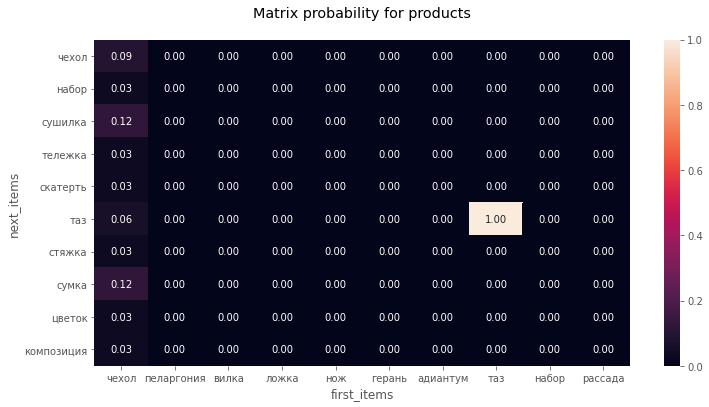

In [477]:
# вид матрицы для первых 10 столбцов и строк
sns.heatmap(result_prob.iloc[:10,:10], annot=True, fmt=".2f")
plt.title('Matrix probability for products'+ '\n')
plt.xlabel('first_items')
plt.show();

In [484]:
result_prob['чехол'].nlargest(max_n_rec_items*2).reset_index()

,next_items,чехол
0,сушилка,0.125
1,сумка,0.125
2,чехол,0.094
3,таз,0.062
4,щетка,0.062
5,ложка,0.062
6,набор,0.031
7,тележка,0.031
8,скатерть,0.031
9,стяжка,0.031


In [479]:
result_prob.to_csv('probability_matrix.csv')

# Расчет скоринга для сортировки товарных рекомендаций

Если к вероятности добавим информацию о стоимости товара, то получим математическое ожидание выручки.

Мат. ожидание выручки будем использовать для сортировки товаров для рекомендаций.

In [480]:
items_price_median = df.groupby('category')['price'].median().reset_index()

In [481]:
result_scoring = result_prob.copy()
result_scoring = result_scoring.T


for column in result_scoring:
    cost = items_price_median[items_price_median[item] == column]['price'].sum()
    result_scoring[column] = result_scoring[column] * cost
    
result_scoring = result_scoring.T

In [482]:
result_scoring['чехол'].nlargest(round(max_n_rec_items*2)).reset_index()

,next_items,чехол
0,сумка,206.125
1,сушилка,81.500
2,скатерть,30.438
3,штора,30.438
4,простыня,29.281
5,чехол,28.031
6,чайник,23.406
7,тележка,22.938
8,контейнер,21.062
9,таз,14.938


Text(0.5, 1.0, 'Диаграмма скоринга для каждого следующего товара\n')

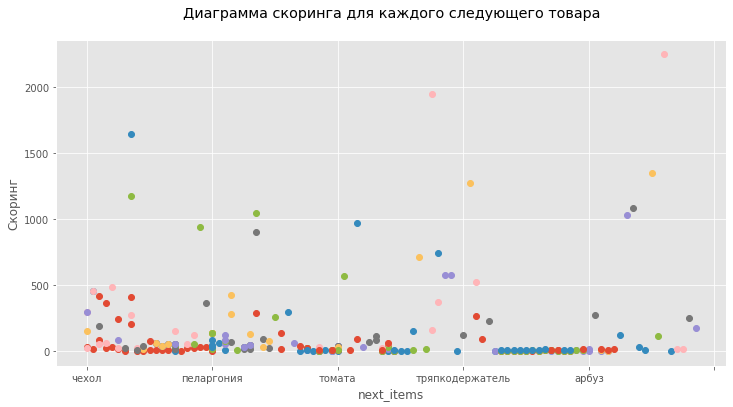

In [497]:
result_scoring[result_scoring>0].plot(style='o', legend=False)

plt.ylabel('Скоринг')
plt.title('Диаграмма скоринга для каждого следующего товара'+'\n')

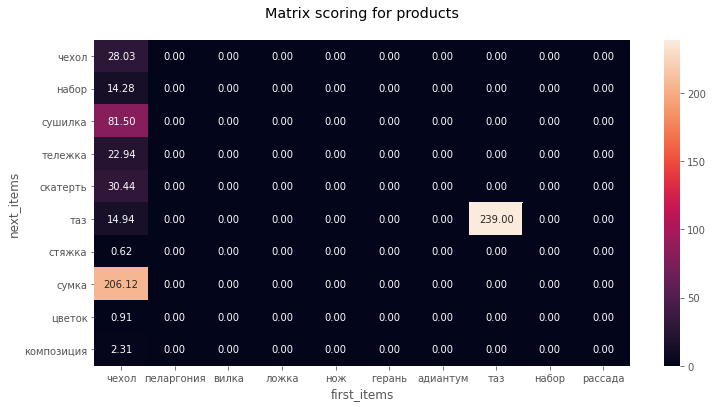

In [498]:
# вид матрицы для первых 10 столбцов и строк
sns.heatmap(result_scoring.iloc[:10,:10], annot=True, fmt=".2f")
plt.title('Matrix scoring for products'+ '\n')
plt.xlabel('first_items')
plt.show();

In [499]:
df[df['category'] == 'таз']['price'].median()

239.0

# Формирование товарных рекомендаций для клиентов

In [500]:
# найдем х2 рекомендуемых товаров для каждого клиента

In [501]:
first_orders = df[df['serial_order'] == 1][['order_id', 'customer_id', 'regular']].drop_duplicates()

In [502]:
# создадим таблицу с товарами в разрезе первых заказов

items_first_all = df[(df['order_id'].isin(first_orders['order_id']))][['order_id', 'customer_id', 'category']]
items_first_all.sample()

,order_id,customer_id,category
3765,14848,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,роза


In [503]:
# добавим в result товары по которым отсутствуют рекомендации

temp2 = pd.DataFrame(index=df[~df['category'].isin(result_scoring.T.reset_index()['index'])]['category'].unique().tolist())
result_scoring = pd.concat([result_scoring.T, temp2]).fillna(0).T

In [408]:
%%time
rec_items_orders = pd.DataFrame() # заготовка для будущего результата

for order_number in tqdm(items_first_all['order_id'].unique()): # идем по всем уникальным первым заказам

    # обнуляем таблицу куда складываем все товары, которые рекомендуем для заказа
    
    all_items = pd.DataFrame(columns=[0]) 
    
    for items in items_first_all[items_first_all['order_id'] == order_number]['category'].unique():
        
        # складываем все рекомендуемые товары
        
        items_for_orders = result_scoring[result_scoring[items]>0][items].sort_values(ascending=False)
        all_items = pd.concat([items_for_orders, all_items])
        
        # сортируем и удаляем дубликаты из таблицы, куда складываем все товары
        
        all_items_update = all_items.sort_values(by=0, ascending=False).reset_index().drop_duplicates(subset='index').set_index('index')
        all_items_update.columns = [order_number]
        all_items_update = all_items_update.fillna(0)
        
        # если находим товары для рекомендаций, то берем max и добавляем в результирующую таблицу
        
        if all_items_update.sum().sum() > 0:
            all_items_update = all_items_update.nlargest(max_n_rec_items*2, order_number)
            rec_items_orders = pd.concat([rec_items_orders, all_items_update])

rec_items_orders = rec_items_orders.fillna(0).reset_index().groupby('index').sum()


CPU times: user 1min 33s, sys: 46.2 s, total: 2min 19s
Wall time: 2min 18s


In [409]:
rec_items_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, алиссум to этажерка
Columns: 1927 entries, 13547 to 73162
dtypes: float64(1927)
memory usage: 1.4+ MB


In [504]:
# проверяем заказы с самым низким скором

for x in rec_items_orders.columns:
    if rec_items_orders[x].sum() < 30:
        print(x, rec_items_orders[x].sum())

68510 29.0
68592 20.0
69934 29.0
70179 29.0
70450 29.0
71007 15.0
71232 15.0
71885 20.0
71954 29.0
72414 15.0
72734 15.0
72748 29.0
73032 20.0


In [506]:
%%time

# Найдем лучшие товары для клиентов, которым удалось подобрать рекомендации

rec_items_clients = pd.DataFrame(columns=['items', 'scoring', 'order_id', 'customer_id'])

# идем по всем уникальным заказам для которых мы смогли подобрать рекомендации

for order_id in tqdm(rec_items_orders.columns):
    
    # ищем Топ-6 товаров, больше нуля для каждого номера заказа
    
    temp = pd.DataFrame(rec_items_orders[order_id].nlargest(max_n_rec_items)[rec_items_orders[order_id].nlargest(max_n_rec_items) > 0]).reset_index()
    
    # формируем датасет в нашем стиле
    
    temp['order_id'] = order_id
    temp['customer_id'] = df[df['order_id']==order_id]['customer_id'].unique().min()
    temp.columns = ['items', 'scoring', 'order_id', 'customer_id']
    if len(temp) >= min_n_rec_items: # проверяем что рекомендованных товаров больше min_n_rec_items
        rec_items_clients = pd.concat([rec_items_clients,temp]) # объединяем со всеми предыдущими


CPU times: user 14.5 s, sys: 185 ms, total: 14.7 s
Wall time: 14.5 s


In [507]:
rec_items_clients

,items,scoring,order_id,customer_id
0,рассада,53.250,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
1,петуния,12.000,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
2,пеларгония,10.547,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
3,томата,5.700,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
4,растение,5.125,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
...,...,...,...,...
2,ведро,10.643,73158,1f0a7f35-7459-4f23-b468-5e45bf481dd1
3,шнур,5.286,73158,1f0a7f35-7459-4f23-b468-5e45bf481dd1
0,доска,1049.333,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea
1,герань,33.111,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea


# Анализ результирующего файла

## По товарам

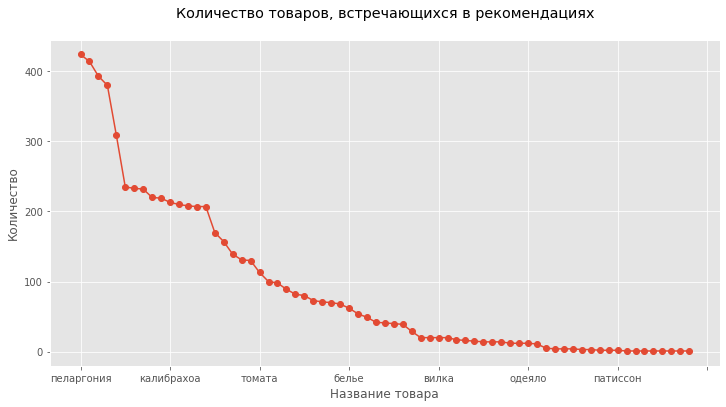

In [509]:
rec_items_clients['items'].value_counts().plot(style='o-')
plt.xlabel('Название товара')
plt.ylabel('Количество')
plt.title('Количество товаров, встречающихся в рекомендациях'+'\n');

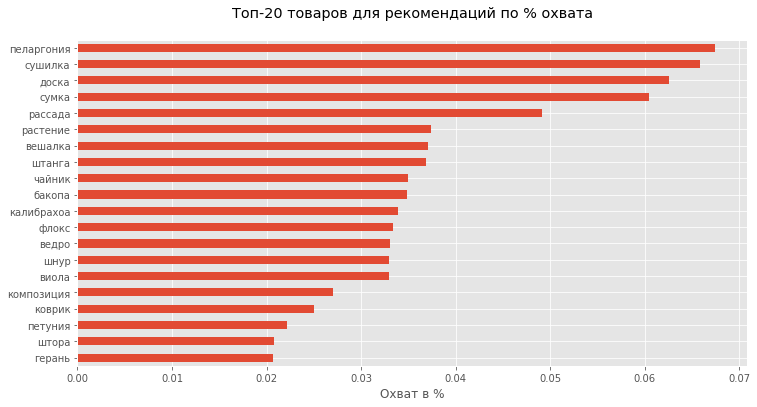

In [512]:
rec_items_clients['items'].value_counts(normalize=True).head(20).sort_values().plot(kind='barh')

plt.xlabel('Охват в %')
plt.title('Топ-20 товаров для рекомендаций по % охвата'+'\n');

In [513]:
print('Охват Топ-5 самых популярных товаров в рекомендациях: {:.2%}'.format(rec_items_clients['items'].value_counts(normalize=True).head().sum()))

Охват Топ-5 самых популярных товаров в рекомендациях: 30.55%


In [514]:
print('Всего уникальных товаров для рекомендаций:', rec_items_clients['items'].nunique())
print('Доля товаров, участвующих в рекомендациях: {:.2%}'.format( 
     rec_items_clients['items'].nunique() /\
     df[df['regular'] == 0]['category'].nunique()))

Всего уникальных товаров для рекомендаций: 69
Доля товаров, участвующих в рекомендациях: 18.35%


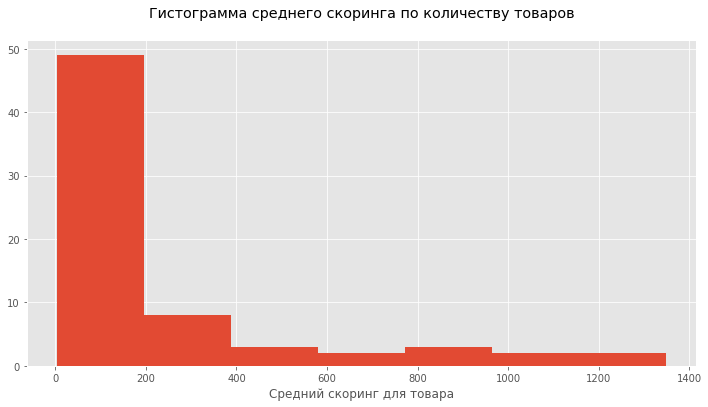

In [423]:
rec_items_clients.groupby('items')['scoring'].mean().hist(bins=7)

plt.xlabel('Средний скоринг для товара')
plt.title('Гистограмма среднего скоринга по количеству товаров'+'\n');

## По клиентам

In [419]:
print('Клиентов с рекомендациями:', rec_items_clients['customer_id'].nunique())
print('Доля клиентов получивших рекомендацию: {:.2%}'.format( 
     rec_items_clients['customer_id'].nunique() /\
     df[df['regular'] == 0]['customer_id'].nunique()))

Клиентов с рекомендациями: 1518
Доля клиентов получивших рекомендацию: 66.40%


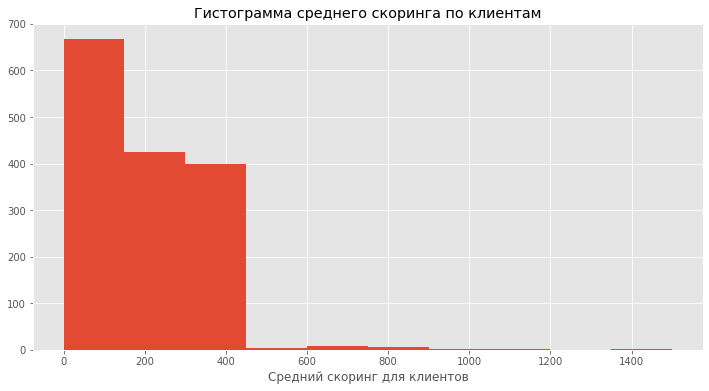

In [422]:
rec_items_clients.groupby('customer_id')['scoring'].mean().hist(range=(0,1500))

plt.xlabel('Средний скоринг для клиентов')
plt.title('Гистограмма среднего скоринга по клиентам');

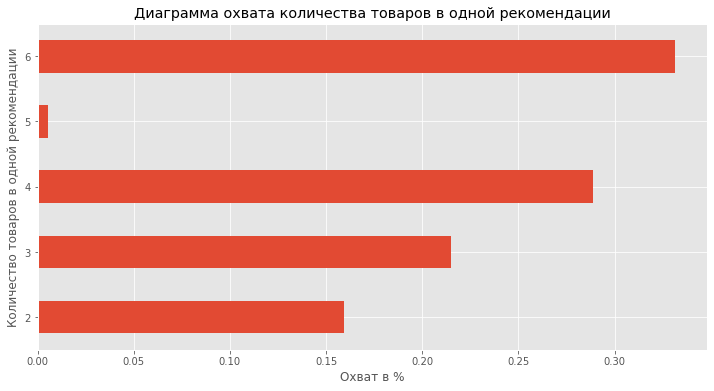

In [425]:
# как распределяется количество товаров на одного клиента

rec_items_clients['order_id'].value_counts().value_counts(normalize=True).sort_index().plot(kind='barh')

plt.xlabel('Охват в %')
plt.ylabel('Количество товаров в одной рекомендации')
plt.title('Диаграмма охвата количества товаров в одной рекомендации');

In [520]:
# проверяем на наличие повторяющихся товаров в одной рекомендации

temp = rec_items_clients.groupby('order_id')['items'].agg(['count', 'nunique'])
len(temp[temp['count'] != temp['nunique']])

0

# Заключение

In [213]:
stop

NameError: name 'stop' is not defined

In [212]:
rec_items_clients.to_csv('rec_items_clients_final.csv')

На основе лога покупок в интернет магазине за определенный период были подготовлены товарные рекомендации для последующей Email рассылки. Формат результирующего файла определен сервисом Email рассылки - MindBox.

Для вычисления товаров для рекомендаций использовался следующий алгоритм:
1. Расчет вероятности заказа товара Y, если в первом заказе присутствует товар Х на основании заказов постоянных клиентов 
2. Расчет скоринга для каждого товара на основе произведения медианной стоимости и вероятности заказа
3. Подготовка товарных рекомендаций на основе состава корзины для клиентов, совершивших первый заказ
